In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product 

df_val = pd.read_csv('val_pred_20231229_135529.csv')
df_test = pd.read_csv('test_pred_20231229_135529.csv')
df_with_weekends  = pd.read_csv('csv/BTC-USD/BTC-USD_with_weekends.csv')

In [ ]:
def get_close_pred(df_prediction, df, prefix, step):   
    df_pred = df_prediction.copy() 
    row_number_start = df.loc[df['Date'] == df_pred.iloc[0]['Date']].index[0]
    row_number_end = df.loc[df['Date'] == df_pred.iloc[-1]['Date']].index[0]
    df_pred['Close_pred'] = np.exp(df_pred['NHITS']) *  df[prefix+'_Close'][row_number_start-step:row_number_end+1-step].values.flatten()
    df_pred['Close'] = df[prefix+'_Close'][row_number_start:row_number_end+1].values.flatten()
        
    close = df[prefix+'_Close'][row_number_start-1:row_number_end].values.flatten()[0::step]
    df_pred['Close_buy'] = [element for element in close for _ in range(step)]

    df_pred['Ratio_pred'] = ((df_pred['Close_pred'] - df_pred['Close_buy']) / df_pred['Close_buy'])*100

    return df_pred

def calculate_return(df, thr_p, thr_m, intrest, idx_trust):
    return_list = []
    for _, row in df.iterrows():
        if row['sequenceID'] < idx_trust:
            if row['Ratio_pred'] > thr_p:
                money_prc = (row['Close_buy']*(1-intrest) - row['Close']*(1+intrest))/row['Close_buy']
                return_list.append(money_prc)

            if row['Ratio_pred'] < thr_m:
                money_prc = (row['Close']*(1-intrest) - row['Close_buy']*(1+intrest))/row['Close_buy']
                return_list.append(money_prc)

    if return_list:
        return np.mean(return_list), return_list
    else:
        return 0, None
        
def optimize_parameters(df,step):

    thr_p_range = np.arange(0.1, 1.0, 0.05)
    thr_m_range = np.arange(-1.0, 0, 0.05)
    idx_trust_range = range(2, step) 
    intrest_range = [0.002]
    max_mean_return = -np.inf
    best_params = None


    for thr_p, thr_m, intrest, idx_trust in product(thr_p_range, thr_m_range, intrest_range, idx_trust_range):
        mean_return, _ = calculate_return(df, thr_p, thr_m, intrest, idx_trust)
        if mean_return > max_mean_return:
            max_mean_return = mean_return
            best_params = (thr_p, thr_m, intrest, idx_trust)

    return best_params, max_mean_return

In [58]:
prefix = 'BTC-USD'
df = df_with_weekends
step = 7
df_val = get_close_pred(df_val, df, prefix, step)
df_test = get_close_pred(df_test, df, prefix, step)

In [79]:
df_val.head(10)

,unique_id,ds,NHITS,index,y,modelID,sequenceID,Date,Close_pred,Close,Close_buy,Ratio_pred
0,BTC-USD,2023-08-05,-0.010954,0,-0.010781,0,0,2023-08-05,29037.097361,29042.126953,29074.091797,-0.127242
1,BTC-USD,2023-08-06,-0.009493,1,-0.008006,0,1,2023-08-06,28998.719783,29041.855469,29074.091797,-0.259241
2,BTC-USD,2023-08-07,-0.008661,2,-0.001696,0,2,2023-08-07,28978.039226,29180.578125,29074.091797,-0.330372
3,BTC-USD,2023-08-08,-0.008890,3,0.003020,0,3,2023-08-08,29413.070742,29765.492188,29074.091797,1.165914
4,BTC-USD,2023-08-09,-0.009797,4,0.013951,0,4,2023-08-09,28867.760406,29561.494141,29074.091797,-0.709674
5,BTC-USD,2023-08-10,-0.007175,5,0.008562,0,5,2023-08-10,28970.083634,29429.591797,29074.091797,-0.357735
6,BTC-USD,2023-08-11,-0.008773,6,0.011069,0,6,2023-08-11,28820.151918,29397.714844,29074.091797,-0.873423
7,BTC-USD,2023-08-12,0.008433,7,0.012790,1,0,2023-08-12,29288.060831,29415.964844,29397.714844,-0.373002
8,BTC-USD,2023-08-13,0.010046,8,0.008266,1,1,2023-08-13,29335.076872,29282.914062,29397.714844,-0.213071
9,BTC-USD,2023-08-14,0.010476,9,0.007778,1,2,2023-08-14,29487.874651,29408.443359,29397.714844,0.306690


In [ ]:
#calculate corralation between price and close in df_val
correlation = df_val['Close'].corr(df_val['Close_pred'])
print('Correlation between Price and Close:', correlation)

In [ ]:
best_params, max_mean_return = optimize_parameters(df_val,step)
print('Best params val: ', best_params)
print('Max mean return val: ', max_mean_return)
mean_return, return_list = calculate_return(df_test, *best_params)
print('Mean return test: ', mean_return)

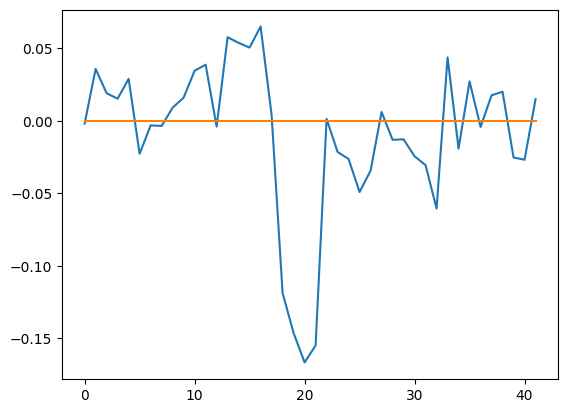

In [120]:
plt.plot(return_list)
plt.plot([0 for _ in range(len(return_list))])